## #413yaw99

### The analysis regarding SpeedDating data:
- This analysis is to investigate what drives people got matched or not matached in speed dating applying multivariate approach
- to simplify the process due to time constraint, sample with wave=6,7,8,9 were excluded becasue of involving different scale of 1-10 instead of 100 sum points. Furthermore, variables with more than 40% missing values will be dropped
- then, I aggregated multiple vairables if they have the same prifix i.e. Attractive/Sincere/Inteligent/Fun/Ambitious/SharedInterests by taking the mean values across times (the follow-up rounds)
- next, I checked the proportion of the missing values and imputed them. If the variables are ordinal or categorical in nature the median imputation was used, otherwise the mean value imputation applying simple imputation will be carried out. 
- after that, the numeric data were further standardized approach and the descriptive analysis was carried out
- finally, I recoded and selected the variables used in the analytic process, followed by a correlation heatmap demonstrated prior to the modelling procedure.
- a logit model was conducted to determine which factors impact the match or non-match outcome. I first run the conventional logit model using statsmodel for quickly extracting significant variables, and then I operated the learning-based logit model via data spliting procedure. Besides, the model performance, accuracy score, feature importance and classification report of the logit model are presented

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model  import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.patches as mpatches
from math import pi
import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv("SpeedDating.csv", encoding='latin1')
print(df.shape[0], 'observations and', df.shape[1], 'features')

8378 observations and 195 features


In [3]:
# wave 6-9 rated importance using a scale of 1-10, others used 100 points.
# for the time-being and my conveninence, I decided to remove the less common scaling approach, as it doesn't make sense to normalize/standardize different scaling methods
df_100_points = (df.wave != 6 ) &(df.wave != 7 ) & (df.wave != 8 ) &(df.wave != 9 ) 
df = df[df_100_points]
print(df.shape[0], 'observations and', df.shape[1], 'features')

6816 observations and 195 features


<AxesSubplot:title={'center':'distribution of missing values'}>

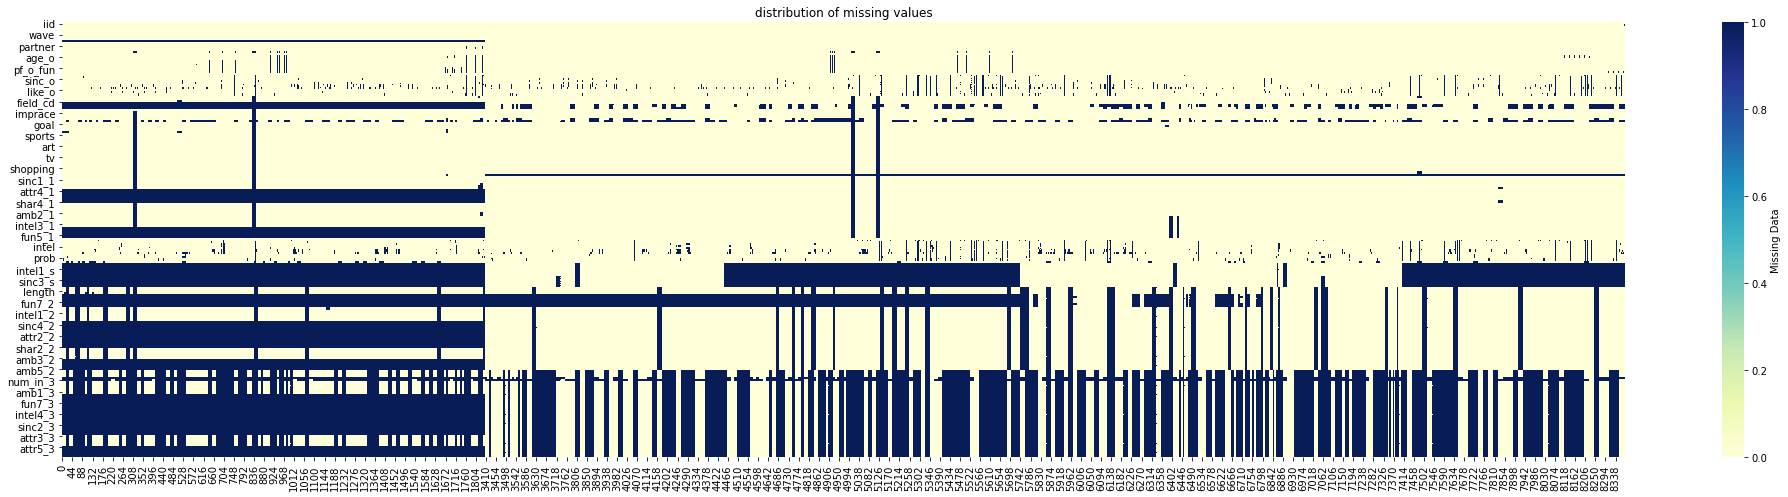

In [4]:
plt.figure(figsize=(35,8))
plt.title('distribution of missing values')
sns.heatmap(df.isna().transpose(),cmap="YlGnBu", cbar_kws={'label': 'Missing Data'})
## too many missing values!

In [5]:
##dealing with missing values
def rmissingvaluecol(dff, threshold):
    l = []
    l = list(dff.drop(dff.loc[:,list((100*(dff.isnull().sum()/len(dff.index)) >= threshold))].columns, 1).columns.values)
    print("# Columns having more than %s percent missing values: "%threshold, (dff.shape[1] - len(l)))
    print("Columns:\n", list(set(list((dff.columns.values))) - set(l)))
    return l
rmissingvaluecol(df,40) # I am going to drop columns having more than 40% of missing values

# Columns having more than 40 percent missing values:  60
Columns:
 ['sinc1_s', 'fun2_3', 'intel1_s', 'amb3_s', 'fun7_3', 'intel5_3', 'shar7_3', 'shar7_2', 'date_3', 'shar4_3', 'sinc7_2', 'sinc3_s', 'sinc1_3', 'amb7_3', 'sinc3_3', 'sinc5_3', 'amb4_3', 'you_call', 'sinc4_3', 'intel7_3', 'fun4_3', 'fun5_3', 'amb5_3', 'amb2_3', 'shar1_3', 'attr5_3', 'shar1_s', 'intel3_3', 'them_cal', 'sinc2_3', 'attr3_s', 'income', 'attr1_3', 'fun1_s', 'numdat_3', 'shar2_3', 'attr3_3', 'fun7_2', 'attr1_s', 'intel7_2', 'amb7_2', 'tuition', 'sinc7_3', 'intel3_s', 'attr2_3', 'amb3_3', 'fun1_3', 'attr4_3', 'intel1_3', 'attr7_3', 'fun3_3', 'intel4_3', 'fun3_s', 'expnum', 'intel2_3', 'mn_sat', 'amb1_s', 'num_in_3', 'attr7_2', 'amb1_3']


['iid',
 'id',
 'gender',
 'idg',
 'condtn',
 'wave',
 'round',
 'position',
 'positin1',
 'order',
 'partner',
 'pid',
 'match',
 'int_corr',
 'samerace',
 'age_o',
 'race_o',
 'pf_o_att',
 'pf_o_sin',
 'pf_o_int',
 'pf_o_fun',
 'pf_o_amb',
 'pf_o_sha',
 'dec_o',
 'attr_o',
 'sinc_o',
 'intel_o',
 'fun_o',
 'amb_o',
 'shar_o',
 'like_o',
 'prob_o',
 'met_o',
 'age',
 'field',
 'field_cd',
 'undergra',
 'race',
 'imprace',
 'imprelig',
 'from',
 'zipcode',
 'goal',
 'date',
 'go_out',
 'career',
 'career_c',
 'sports',
 'tvsports',
 'exercise',
 'dining',
 'museums',
 'art',
 'hiking',
 'gaming',
 'clubbing',
 'reading',
 'tv',
 'theater',
 'movies',
 'concerts',
 'music',
 'shopping',
 'yoga',
 'exphappy',
 'attr1_1',
 'sinc1_1',
 'intel1_1',
 'fun1_1',
 'amb1_1',
 'shar1_1',
 'attr4_1',
 'sinc4_1',
 'intel4_1',
 'fun4_1',
 'amb4_1',
 'shar4_1',
 'attr2_1',
 'sinc2_1',
 'intel2_1',
 'fun2_1',
 'amb2_1',
 'shar2_1',
 'attr3_1',
 'sinc3_1',
 'fun3_1',
 'intel3_1',
 'amb3_1',
 'attr5_1',

In [6]:
df.drop(df[['attr3_3', 'attr2_3', 'sinc2_3', 'attr7_2', 'intel7_3', 'sinc7_2', 'expnum', 'amb7_2', 'intel3_3', 'tuition', 'intel2_3', 'attr3_s', 
            'shar7_3', 'amb1_3', 'sinc5_3', 'sinc1_s', 'them_cal', 'fun7_3', 'fun3_3', 'attr1_s', 'attr7_3', 'fun3_s', 'amb3_3', 'amb1_s', 'numdat_3', 
            'intel3_s', 'intel5_3', 'fun1_3', 'sinc3_3', 'shar1_3', 'sinc4_3', 'sinc3_s', 'intel1_3', 'attr4_3', 'income', 'amb2_3', 'num_in_3', 
            'amb7_3', 'attr1_3', 'you_call', 'fun1_s', 'intel7_2', 'fun2_3', 'intel4_3', 'fun5_3', 'sinc1_3', 'amb5_3', 'shar4_3', 'shar7_2', 'amb4_3', 
            'shar2_3','sinc7_3', 'intel1_s', 'amb3_s', 'date_3', 'fun4_3', 'shar1_s', 'mn_sat', 'fun7_2', 'attr5_3']],axis=1,inplace=True)  # 60 variables dropped
df=pd.DataFrame(df)
df.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_2,sinc3_2,intel3_2,fun3_2,amb3_2,attr5_2,sinc5_2,intel5_2,fun5_2,amb5_2
0,1,1.0,0,1,1,1,10,7,NaN,4,...,6.0,7.0,8.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,6.0,7.0,8.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,6.0,7.0,8.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,6.0,7.0,8.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,6.0,7.0,8.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN


In [7]:
# get averaged value of columns with similar prefix across 3 times
# attractive/ sincere/ intelligent/ fun/ ambitious/ shared interest/ partners' stated preference at the first time
idx = df.columns.str.startswith('attr')
df['attrative_avg'] = df.iloc[:,idx].mean(axis=1)

idx = df.columns.str.startswith('sinc')
df['sincere_avg'] = df.iloc[:,idx].mean(axis=1)

idx = df.columns.str.startswith('intel')
df['intelligent_avg'] = df.iloc[:,idx].mean(axis=1)

idx = df.columns.str.startswith('fun')
df['fun_avg'] = df.iloc[:,idx].mean(axis=1)

idx = df.columns.str.startswith('amb')
df['ambitious_avg'] = df.iloc[:,idx].mean(axis=1)

idx = df.columns.str.startswith('shar')
df['has_shared_interest_avg'] = df.iloc[:,idx].mean(axis=1)

idx = df.columns.str.startswith('pf_o_')
df['partners_SP_time1_avg'] = df.iloc[:,idx].mean(axis=1)

df_final=df[['iid','gender','condtn','round','order','match','int_corr','samerace','age_o','race_o','dec_o', 'age','race','imprace',
             'imprelig','goal','date','go_out','exphappy','attrative_avg','sincere_avg','intelligent_avg','fun_avg','ambitious_avg','has_shared_interest_avg','partners_SP_time1_avg']]

df_final.head()   #this is the final reduced dataset I will use in analysis

,iid,gender,condtn,round,order,match,int_corr,samerace,age_o,race_o,...,date,go_out,exphappy,attrative_avg,sincere_avg,intelligent_avg,fun_avg,ambitious_avg,has_shared_interest_avg,partners_SP_time1_avg
0,1,0,1,10,4,0,0.14,0,27.0,2.0,...,7.0,1.0,3.0,13.348571,12.667143,11.412857,12.460000,8.301429,9.534,16.666667
1,1,0,1,10,3,0,0.54,0,22.0,2.0,...,7.0,1.0,3.0,13.634286,12.524286,11.698571,12.460000,8.015714,9.534,16.666667
2,1,0,1,10,10,1,0.16,1,22.0,4.0,...,7.0,1.0,3.0,13.777143,12.810000,11.984286,12.888571,8.444286,10.734,16.666667
3,1,0,1,10,5,1,0.61,0,23.0,2.0,...,7.0,1.0,3.0,13.634286,12.238571,11.698571,12.460000,8.444286,10.534,16.666667
4,1,0,1,10,7,1,0.21,0,24.0,3.0,...,7.0,1.0,3.0,13.491429,12.095714,11.555714,12.174286,8.444286,9.934,16.666667


In [8]:
## there are many peception scales regarding attribtues, here I just wanted to have a quick overview on this:
def radar(categories, data1, data2, label1, label2, scale, title):
    N = len(cat)
    x_as = [n / float(N) * 2 * pi for n in range(N)]
    # Because our chart will be circular we need to append a copy of the first 
    # value of each list at the end of each list with data
    data1 += data1[:1]
    data2 += data2[:1]
    x_as += x_as[:1]
    plt.rc('axes', linewidth=0.5, edgecolor="#888888") # Set color of axes
    ax = plt.subplot(111, polar=True) # Create polar plot
    # Set clockwise rotation. That is:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0) # Set position of y-labels
    # Set color and linestyle of grid
    ax.xaxis.grid(True, color="#888888", linestyle='solid', linewidth=0.5)
    ax.yaxis.grid(True, color="#888888", linestyle='solid', linewidth=0.5)
    plt.xticks(x_as[:-1], [])  # Set number of radial axes and remove labels
    plt.yticks([0, int(scale/2)], ["0", str(int(scale/2))])  # Set yticks
    ax.plot(x_as, data1, linewidth=0, linestyle='solid', zorder=3)
    ax.fill(x_as, data1, 'r', alpha=0.5)
    ax.plot(x_as, data2, linewidth=0, linestyle='solid', zorder=3)
    ax.fill(x_as, data2, 'g', alpha=0.5)
    plt.ylim(0, scale) # Set axes limits

    for i in range(N):  # Draw ytick labels to make sure they fit properly
        angle_rad = i / float(N) * 2 * pi
        if angle_rad == 0:
            ha, distance_ax = "center", 10
        elif 0 < angle_rad < pi:
            ha, distance_ax = "left", 1
        elif angle_rad == pi:
            ha, distance_ax = "center", 1
        else:
            ha, distance_ax = "right", 1
        ax.text(angle_rad, .7 * scale +  distance_ax, cat[i], size=10, horizontalalignment=ha, verticalalignment="center")
    
    b_patch = mpatches.Patch(color='red', label=label1)
    g_patch = mpatches.Patch(color='green', label=label2)
    plt.legend(bbox_to_anchor=(1.1, 1), handles=[b_patch,g_patch])
    plt.title(title, loc="left",y=1.1)
    plt.show()

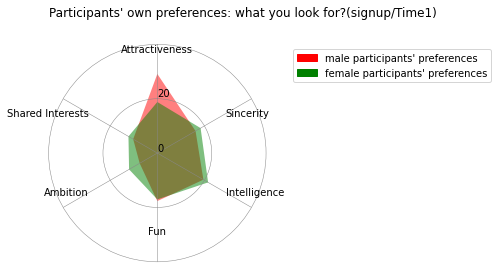

In [9]:
male = df.loc[df['gender'] == 1]
female = df.loc[df['gender'] == 0]
male_preference = [male['attr1_1'].mean(skipna=True), male['sinc1_1'].mean(skipna=True), male['intel1_1'].mean(skipna=True), male['fun1_1'].mean(skipna=True), male['amb1_1'].mean(skipna=True), male['shar1_1'].mean(skipna=True)]
female_preference = [female['attr1_1'].mean(skipna=True), female['sinc1_1'].mean(skipna=True), female['intel1_1'].mean(skipna=True), female['fun1_1'].mean(skipna=True), female['amb1_1'].mean(skipna=True), female['shar1_1'].mean(skipna=True)]
cat = ['Attractiveness', 'Sincerity', 'Intelligence', 'Fun', 'Ambition','Shared Interests']
radar(cat,male_preference,female_preference, "male participants' preferences", "female participants' preferences", 40, "Participants' own preferences: what you look for?(signup/Time1)")

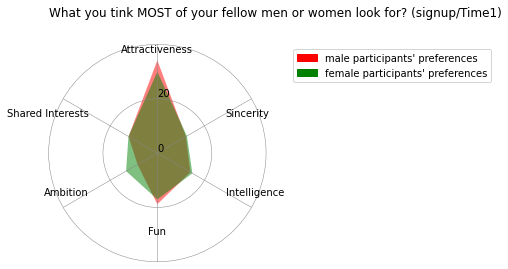

In [10]:
male_preference1 = [male['attr4_1'].mean(skipna=True), male['sinc4_1'].mean(skipna=True), male['intel4_1'].mean(skipna=True), male['fun4_1'].mean(skipna=True), male['amb4_1'].mean(skipna=True), male['shar4_1'].mean(skipna=True)]
female_preference1 = [female['attr4_1'].mean(skipna=True), female['sinc4_1'].mean(skipna=True), female['intel4_1'].mean(skipna=True), female['fun4_1'].mean(skipna=True), female['amb4_1'].mean(skipna=True), female['shar1_1'].mean(skipna=True)]
cat = ['Attractiveness', 'Sincerity', 'Intelligence', 'Fun', 'Ambition','Shared Interests']
radar(cat,male_preference1,female_preference1, "male participants' preferences", "female participants' preferences", 40, "What you tink MOST of your fellow men or women look for? (signup/Time1)")

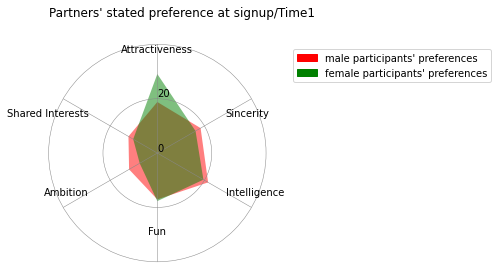

In [11]:
male_preference2 = [male['pf_o_att'].mean(skipna=True), male['pf_o_sin'].mean(skipna=True), male['pf_o_int'].mean(skipna=True), male['pf_o_fun'].mean(skipna=True), male['pf_o_amb'].mean(skipna=True), male['pf_o_sha'].mean(skipna=True)]
female_preference2 = [female['pf_o_att'].mean(skipna=True), female['pf_o_sin'].mean(skipna=True), female['pf_o_int'].mean(skipna=True), female['pf_o_fun'].mean(skipna=True), female['pf_o_amb'].mean(skipna=True), female['pf_o_sha'].mean(skipna=True)]
cat = ['Attractiveness', 'Sincerity', 'Intelligence', 'Fun', 'Ambition','Shared Interests']
radar(cat,male_preference2,female_preference2, "male participants' preferences", "female participants' preferences", 40, "Partners' stated preference at signup/Time1")

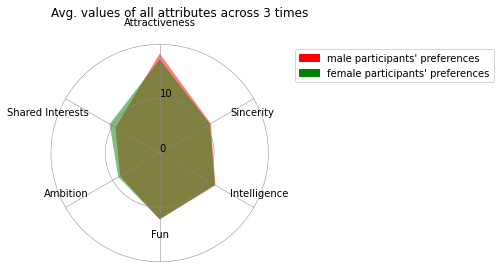

In [12]:
male_preference3 = [male['attrative_avg'].mean(skipna=True), male['sincere_avg'].mean(skipna=True), male['intelligent_avg'].mean(skipna=True), male['fun_avg'].mean(skipna=True), male['ambitious_avg'].mean(skipna=True), male['has_shared_interest_avg'].mean(skipna=True)]
female_preference3 = [female['attrative_avg'].mean(skipna=True), female['sincere_avg'].mean(skipna=True), female['intelligent_avg'].mean(skipna=True), female['fun_avg'].mean(skipna=True), female['ambitious_avg'].mean(skipna=True), female['has_shared_interest_avg'].mean(skipna=True)]
cat = ['Attractiveness', 'Sincerity', 'Intelligence', 'Fun', 'Ambition','Shared Interests']
radar(cat,male_preference3,female_preference3, "male participants' preferences", "female participants' preferences", 20, "Avg. values of all attributes across 3 times")

<AxesSubplot:title={'center':'missing value distribution'}>

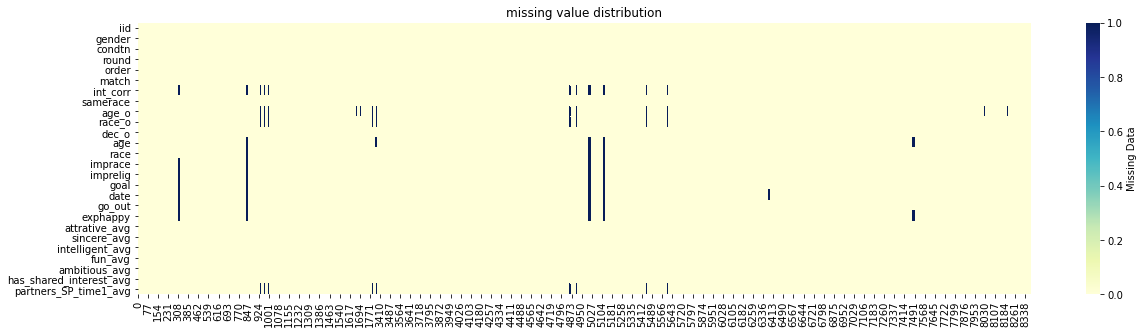

In [13]:
plt.figure(figsize=(20,5))
plt.title('missing value distribution')
sns.heatmap(df_final.isna().transpose(),cmap="YlGnBu", cbar_kws={'label': 'Missing Data'})
## now, I will take care of the leftover missing values

In [14]:
#Imputing missing values with means because the columns with missing values are all numeric
imputer = SimpleImputer(missing_values=np.NaN, strategy='median')  # for columnes with interger
df_final.race_o = imputer.fit_transform(df_final['race_o'].values.reshape(-1,1))[:,0]
df_final.race = imputer.fit_transform(df_final['race'].values.reshape(-1,1))[:,0]
df_final.dec_o = imputer.fit_transform(df_final['dec_o'].values.reshape(-1,1))[:,0]
df_final.goal = imputer.fit_transform(df_final['goal'].values.reshape(-1,1))[:,0]
df_final.date = imputer.fit_transform(df_final['date'].values.reshape(-1,1))[:,0]
df_final.go_out= imputer.fit_transform(df_final['go_out'].values.reshape(-1,1))[:,0]
df_final.partners_SP_time1_avg= imputer.fit_transform(df_final['partners_SP_time1_avg'].values.reshape(-1,1))[:,0]

imputer1 = SimpleImputer(missing_values=np.NaN, strategy='mean')   #for columns with numeric values
df_final.int_corr = imputer1.fit_transform(df_final['int_corr'].values.reshape(-1,1))[:,0]
df_final.age_o= imputer1.fit_transform(df_final['age_o'].values.reshape(-1,1))[:,0]
df_final.age = imputer1.fit_transform(df_final['age'].values.reshape(-1,1))[:,0]
df_final.imprace = imputer1.fit_transform(df_final['imprace'].values.reshape(-1,1))[:,0]
df_final.imprelig = imputer1.fit_transform(df_final['imprelig'].values.reshape(-1,1))[:,0]
df_final.exphappy = imputer1.fit_transform(df_final['exphappy'].values.reshape(-1,1))[:,0]
df_final.imprelig = imputer1.fit_transform(df_final['imprelig'].values.reshape(-1,1))[:,0]
df_final.attrative_avg = imputer1.fit_transform(df_final['attrative_avg'].values.reshape(-1,1))[:,0]
df_final.sincere_avg = imputer1.fit_transform(df_final['sincere_avg'].values.reshape(-1,1))[:,0]
df_final.fun_avg = imputer1.fit_transform(df_final['fun_avg'].values.reshape(-1,1))[:,0]
df_final.ambitious_avg = imputer1.fit_transform(df_final['ambitious_avg'].values.reshape(-1,1))[:,0]
df_final.has_shared_interest_avg = imputer1.fit_transform(df_final['has_shared_interest_avg'].values.reshape(-1,1))[:,0]
df_final.intelligent_avg = imputer1.fit_transform(df_final['intelligent_avg'].values.reshape(-1,1))[:,0]

df_final.isnull().sum()  #finally, all missing values are filled

iid                        0
gender                     0
condtn                     0
round                      0
order                      0
match                      0
int_corr                   0
samerace                   0
age_o                      0
race_o                     0
dec_o                      0
age                        0
race                       0
imprace                    0
imprelig                   0
goal                       0
date                       0
go_out                     0
exphappy                   0
attrative_avg              0
sincere_avg                0
intelligent_avg            0
fun_avg                    0
ambitious_avg              0
has_shared_interest_avg    0
partners_SP_time1_avg      0
dtype: int64

In [15]:
## individual_aggregation = scores.groupby('iid').agg('max') ... however, I would rather see each match result independently, instead of involving aggregated data
# descriptive analysis is now followed
df_final[['gender','condtn','match','int_corr','samerace','age_o','race_o','dec_o',
          'age','race','imprace','imprelig','goal','date','go_out','exphappy','attrative_avg','sincere_avg',
          'intelligent_avg','fun_avg','ambitious_avg','has_shared_interest_avg','partners_SP_time1_avg']].describe().round(2)
# based on the output of descritive analysis, I assume I do not worry about outliers

,gender,condtn,match,int_corr,samerace,age_o,race_o,dec_o,age,race,...,date,go_out,exphappy,attrative_avg,sincere_avg,intelligent_avg,fun_avg,ambitious_avg,has_shared_interest_avg,partners_SP_time1_avg
count,6816.0,6816.00,6816.00,6816.00,6816.00,6816.00,6816.00,6816.00,6816.00,6816.00,...,6816.00,6816.00,6816.00,6816.00,6816.00,6816.00,6816.00,6816.00,6816.00,6816.00
mean,0.5,1.83,0.16,0.20,0.39,26.29,2.78,0.42,26.28,2.78,...,5.01,2.16,5.59,17.78,10.77,11.78,12.19,8.60,10.01,16.72
std,0.5,0.38,0.37,0.30,0.49,3.56,1.24,0.49,3.56,1.24,...,1.45,1.15,1.75,5.87,2.58,2.20,2.51,2.12,3.70,0.81
min,0.0,1.00,0.00,-0.73,0.00,18.00,1.00,0.00,18.00,1.00,...,1.00,1.00,1.00,3.50,2.50,3.43,1.00,2.00,0.33,15.00
25%,0.0,2.00,0.00,-0.01,0.00,24.00,2.00,0.00,24.00,2.00,...,4.00,1.00,5.00,13.71,9.14,10.50,10.67,7.17,7.60,16.67
50%,1.0,2.00,0.00,0.20,0.00,26.00,2.00,0.00,26.00,2.00,...,5.00,2.00,6.00,16.33,10.86,11.80,12.25,8.67,9.80,16.67
75%,1.0,2.00,0.00,0.43,1.00,28.00,4.00,1.00,28.00,4.00,...,6.00,3.00,7.00,20.75,12.50,13.08,13.67,10.08,12.50,16.67
max,1.0,2.00,1.00,0.91,1.00,55.00,6.00,1.00,55.00,6.00,...,7.00,7.00,10.00,53.75,24.50,19.60,23.33,21.80,23.33,33.33


In [16]:
df_final.gender.replace([1, 0], ['male', 'female'],inplace=True)
print("Gender distribution:","\n",df_final.groupby('gender', as_index=True)['iid'].nunique())

Gender distribution: 
 gender
female    223
male      226
Name: iid, dtype: int64


In [17]:
#df_final.gender.replace( ['male', 'female'],[1, 0],inplace=True)
df_final.match.replace([1,0], ['Yes','No'], inplace=True)
print("Match distribution:","\n",df_final.groupby('match', as_index=True)['iid'].nunique())

Match distribution: 
 match
No     449
Yes    365
Name: iid, dtype: int64


In [18]:
df_final.match.replace(['Yes','No'],[1,0],  inplace=True)
df_final.race.replace([1,2,3,4,5,6], ['Black/African American', 'European/Caucasian-American','Latino/Hispanic American','Asian/Pacific Islander/Asian American','Native American','Other'], inplace=True)
dummy_gender = pd.get_dummies(df_final['gender'], prefix='gender_')
df_final = pd.merge(left=df_final,right=dummy_gender,left_index=True,right_index=True,)
print("Race distribution:","\n",df_final.groupby('race', as_index=True)['iid'].nunique())

Race distribution: 
 race
Asian/Pacific Islander/Asian American    112
Black/African American                    19
European/Caucasian-American              250
Latino/Hispanic American                  36
Other                                     32
Name: iid, dtype: int64


In [19]:
df_final.race.replace(['Black/African American', 'European/Caucasian-American','Latino/Hispanic American','Asian/Pacific Islander/Asian American','Native American','Other'], [1,2,3,4,5,6], inplace=True)
df_final.goal.replace([1,2,3,4,5,6], ['Seemed like a fun night out','To met new people','To get a date','Looking for a serious relationship','To say I did it','Other'], inplace=True)
dummy_race = pd.get_dummies(df_final['race'], prefix='race_')
df_final = pd.merge(left=df_final,right=dummy_race,left_index=True,right_index=True,)
print("Speeddating goal distribution:","\n",df_final.groupby('goal', as_index=True)['iid'].nunique())

Speeddating goal distribution: 
 goal
Looking for a serious relationship     16
Other                                  26
Seemed like a fun night out           180
To get a date                          34
To met new people                     163
To say I did it                        30
Name: iid, dtype: int64


In [20]:
df_final.goal.replace(['Seemed like a fun night out','To met new people','To get a date','Looking for a serious relationship','To say I did it','Other'],[1,2,3,4,5,6],  inplace=True)
df_final.date.replace([1,2,3,4,5,6,7], ['Several times a week','Twice a week','Once a week','Twice a month','Once a month','Several times a year','Almost never'], inplace=True)
print("Speeddating frequency distribution among entire sample:","\n",df_final.groupby('date', as_index=True)['iid'].nunique())

Speeddating frequency distribution among entire sample: 
 date
Almost never             79
Once a month             85
Once a week              43
Several times a week      6
Several times a year    108
Twice a month           108
Twice a week             20
Name: iid, dtype: int64


In [21]:
df_final.date.replace(['Several times a week','Twice a week','Once a week','Twice a month','Once a month','Several times a year','Almost never'], [1,2,3,4,5,6,7], inplace=True)
# standardizing numeric vairables
from sklearn import preprocessing
df_final["has_shared_interest_avg"] = preprocessing.scale(df_final["has_shared_interest_avg"])
df_final["ambitious_avg"] = preprocessing.scale(df_final["ambitious_avg"])
df_final["fun_avg"] = preprocessing.scale(df_final["fun_avg"])
df_final["intelligent_avg"] = preprocessing.scale(df_final["intelligent_avg"])
df_final["sincere_avg"] = preprocessing.scale(df_final["sincere_avg"])
df_final["attrative_avg"] = preprocessing.scale(df_final["attrative_avg"])
df_final["age"] = preprocessing.scale(df_final["age"])
df_final["age_o"] = preprocessing.scale(df_final["age_o"])
df_final["exphappy"] = preprocessing.scale(df_final["exphappy"])
df_final["partners_SP_time1_avg"] = preprocessing.scale(df_final["partners_SP_time1_avg"])
df_final=pd.DataFrame(df_final)

In [22]:
# recode variables
df_final['extensive_choice'] = np.where(df_final['condtn'] == 2, 1, 0)
df_final['male'] =df.gender
df_final['serious_goal'] = np.where(df_final['goal'] ==4, 1, 0)
df_final['frequent_dates'] = np.where(df_final['date'] >=3, 1, 0)
df_final['often_out'] = np.where(df_final['go_out'] >= 2, 1, 0)
dummy_race_o= pd.get_dummies(df_final['race_o'], prefix='race_partner_')
df_final = pd.merge(left=df_final,right=dummy_race_o,left_index=True,right_index=True,)

In [23]:
# recording race and race_o dummies with more intuitive labels
df_final['race_black/african_american']=df_final['race__1']
df_final['race_european/caucasian_american']=df_final['race__2']
df_final['race_latino/hispanic_american']=df_final['race__3']
df_final['race_asian/pacific_islander_american']=df_final['race__4']
df_final['race_partner_black/african_american']=df_final['race_partner__1.0']
df_final['race_partner_european/caucasian_american']=df_final['race_partner__2.0']
df_final['race_partner_latino/hispanic_american']=df_final['race_partner__3.0']
df_final['race_partner_asian/pacific_islander_american']=df_final['race_partner__4.0']

<AxesSubplot:>

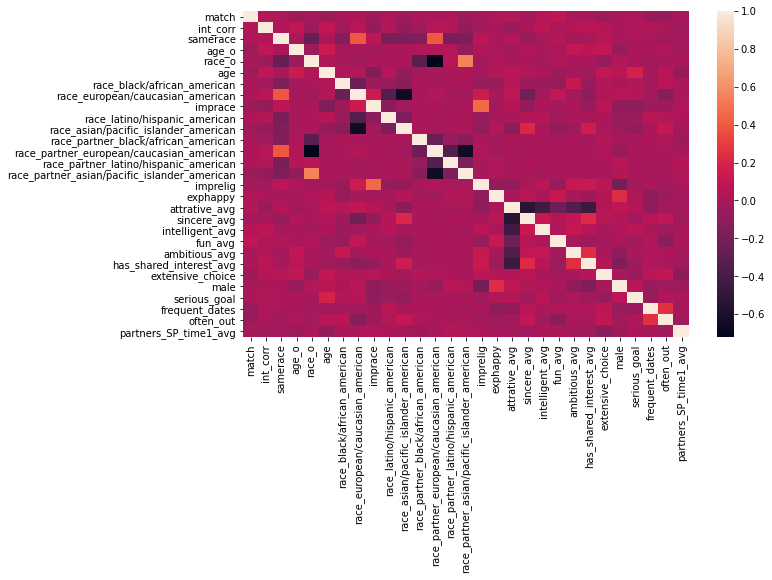

In [24]:
df_final=df_final[['match','int_corr','samerace','age_o','race_o','age','race_black/african_american','race_european/caucasian_american',
                   'imprace','race_latino/hispanic_american','race_asian/pacific_islander_american','race_partner_black/african_american',
                   'race_partner_european/caucasian_american','race_partner_latino/hispanic_american','race_partner_asian/pacific_islander_american',
                   'imprelig','exphappy','attrative_avg','sincere_avg','intelligent_avg','fun_avg','ambitious_avg',
                   'has_shared_interest_avg','extensive_choice','male','serious_goal','frequent_dates','often_out','partners_SP_time1_avg']]
plt.figure(figsize=(10, 6))
sns.heatmap(df_final.corr())
#the heatmap concludes that there is no high correlations among the selected variables

In [25]:
y=df_final['match']
x=df_final[['int_corr','samerace','age_o','race_o','age','race_black/african_american','race_european/caucasian_american',
            'imprace','race_latino/hispanic_american','race_asian/pacific_islander_american','race_partner_black/african_american',
            'race_partner_european/caucasian_american','race_partner_latino/hispanic_american','race_partner_asian/pacific_islander_american',
            'imprelig','exphappy','attrative_avg','sincere_avg','intelligent_avg','fun_avg','ambitious_avg',
            'has_shared_interest_avg','extensive_choice','male','serious_goal','frequent_dates','often_out','partners_SP_time1_avg']]

In [26]:
import statsmodels.api as sm
x_add_constant=sm.add_constant(x)
logit_model_sm = sm.Logit(y, x).fit()  
logit_model_sm.summary()

Optimization terminated successfully.
         Current function value: 0.425506
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  match   No. Observations:                 6816
Model:                          Logit   Df Residuals:                     6788
Method:                           MLE   Df Model:                           27
Date:                Mon, 16 May 2022   Pseudo R-squ.:                 0.04961
Time:                        12:36:24   Log-Likelihood:                -2900.2
converged:                       True   LL-Null:                       -3051.6
Covariance Type:            nonrobust   LLR p-value:                 2.032e-48
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
int_corr                                         0.2706      0.115      2.358      0.018       0.046       0.496
samerace                                         0.2393      0.085      2.808      0.005       0.072       0.406
age_o                                           -0.1579      0.036     -4.347      0.000      -0.229      -0.087
race_o                                          -0.0747      0.038     -1.986      0.047      -0.148      -0.001
age                                             -0.1634      0.037     -4.429      0.000      -0.236      -0.091
race_black/african_american                      0.1171      0.200      0.585      0.559      -0.275       0.510
race_european/caucasian_american                -0.1964      0.137     -1.433      0.152      -0.465       0.072
imprace                                         -0.0541      0.014     -3.781      0.000      -0.082      -0.026
race_latino/hispanic_american                   -0.0201      0.167     -0.120      0.904      -0.347       0.307
race_asian/pacific_islander_american            -0.3373      0.145     -2.319      0.020      -0.622      -0.052
race_partner_black/african_american             -0.4311      0.229     -1.881      0.060      -0.880       0.018
race_partner_european/caucasian_american        -0.5793      0.150     -3.868      0.000      -0.873      -0.286
race_partner_latino/hispanic_american           -0.2336      0.163     -1.431      0.153      -0.554       0.086
race_partner_asian/pacific_islander_american    -0.6436      0.130     -4.951      0.000      -0.898      -0.389
imprelig                                         0.0151      0.014      1.060      0.289      -0.013       0.043
exphappy                                         0.0311      0.035      0.893      0.372      -0.037       0.099
attrative_avg                                    0.6141      0.065      9.487      0.000       0.487       0.741
sincere_avg                                      0.1804      0.045      3.988      0.000       0.092       0.269
intelligent_avg                                  0.3503      0.042      8.389      0.000       0.268       0.432
fun_avg                                          0.3808      0.039      9.755      0.000       0.304       0.457
ambitious_avg                                    0.1094      0.038      2.881      0.004       0.035       0.184
has_shared_interest_avg                          0.2432      0.043      5.719      0.000       0.160       0.327
extensive_choice                                -0.3408      0.089     -3.840      0.000      -0.515      -0.167
male                                            -0.0870      0.073     -1.186      0.236      -0.231       0.057
serious_goal                                    -0.0634      0.197     -0.322      0.748      -0.450       0.323
frequent_dates                                  -0.4259      0.143     -2.980

In [27]:
# this is part of feature engineering: I would like to obtain good variables for the upcoming machine learning
def get_significant_vars(logit_model_sm): 
    var_p_vals_df = pd.DataFrame( logit_model_sm.pvalues )  
    var_p_vals_df['vars'] = var_p_vals_df.index  
    var_p_vals_df.columns = ['pvals', 'vars']
    return list( var_p_vals_df[var_p_vals_df.pvals <= 0.05]['vars'] )
significant_vars = get_significant_vars(logit_model_sm)
significant_vars

['int_corr',
 'samerace',
 'age_o',
 'race_o',
 'age',
 'imprace',
 'race_asian/pacific_islander_american',
 'race_partner_european/caucasian_american',
 'race_partner_asian/pacific_islander_american',
 'attrative_avg',
 'sincere_avg',
 'intelligent_avg',
 'fun_avg',
 'ambitious_avg',
 'has_shared_interest_avg',
 'extensive_choice',
 'frequent_dates']

In [28]:
# here the learning process starts with data spliting
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size=0.25, random_state=99)

In [29]:
from sklearn.linear_model  import LogisticRegression
for c in [10e-2,10e-1, 1,10e+1,10e+2]:
    logit_model= LogisticRegression(C=c,max_iter=999, class_weight='balanced').fit(x_train[significant_vars], y_train)
    print("Model score is: ", logit_model.score(x_test[significant_vars], y_test))

Model score is:  0.6115023474178404
Model score is:  0.6097417840375586
Model score is:  0.6097417840375586
Model score is:  0.6091549295774648
Model score is:  0.6091549295774648


In [30]:
logit_model_final= LogisticRegression(C=10e-2,max_iter=999, class_weight='balanced').fit(x_train[significant_vars], y_train)
train= logit_model_final.score(x_train[significant_vars], y_train)
print("The Accuracy for Training Set is {}".format(train))
print('\n')
print("Intercept is: ", logit_model_final.intercept_)
print('\n')
print("Coefficients are: ", logit_model_final.coef_)
print('\n')
print("Predict probability of Xs: ", logit_model_final.predict_proba(x[significant_vars]))
print('\n')

The Accuracy for Training Set is 0.6240219092331768


Intercept is:  [0.66366014]


Coefficients are:  [[ 0.28330039  0.15945748 -0.11613139  0.02509157 -0.1682552  -0.03880082
  -0.28952353 -0.13653525 -0.41673616  0.66505371  0.19102401  0.3584995
   0.40759104  0.12257537  0.27948789 -0.26392808 -0.38136357]]


Predict probability of Xs:  [[0.58296204 0.41703796]
 [0.50160242 0.49839758]
 [0.47894493 0.52105507]
 ...
 [0.42515354 0.57484646]
 [0.37922073 0.62077927]
 [0.39387168 0.60612832]]




In [31]:
coef_table = pd.DataFrame(list(x_train[significant_vars].columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",logit_model_final.coef_.transpose())
coef_table

,0,Coefs
0,int_corr,0.283300
1,samerace,0.159457
2,age_o,-0.116131
3,race_o,0.025092
4,age,-0.168255
5,imprace,-0.038801
6,race_asian/pacific_islander_american,-0.289524
7,race_partner_european/caucasian_american,-0.136535
8,race_partner_asian/pacific_islander_american,-0.416736
9,attrative_avg,0.665054


<AxesSubplot:title={'center':'Feature Importance'}>

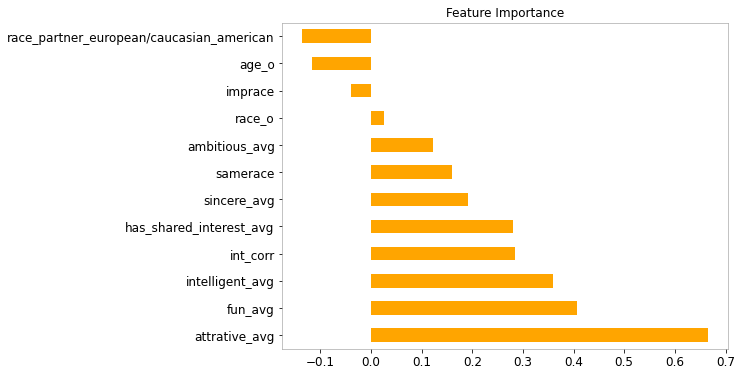

In [32]:
plt.figure(figsize=(8,6))
importance = logit_model_final.coef_[0]
feat_importances = pd.Series(importance, index=x[significant_vars].columns)
feat_importances.nlargest(12).plot(kind='barh',title = 'Feature Importance', color='orange',fontsize=12)

In [33]:
y_pred = logit_model_final.predict(x_test[significant_vars])
test_sc = accuracy_score(y_test, y_pred)
print("The Accuracy for Test Set is {}".format(test_sc))

The Accuracy for Test Set is 0.6115023474178404


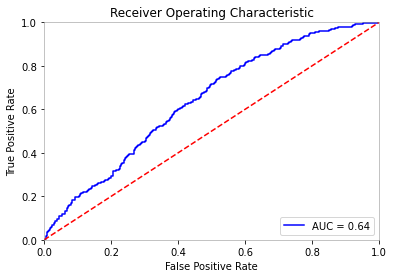

In [34]:
from sklearn import metrics
def plot_roc(model, x_test, y_test):
    # calculate the fpr and tpr for all thresholds of the classification
    probabilities = model.predict_proba(np.array(x_test[significant_vars]))
    predictions = probabilities[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

plot_roc(logit_model_final, x_test[significant_vars], y_test)

[[897 550]
 [112 145]]


Text(0.5, 15.0, 'Predicted Values')

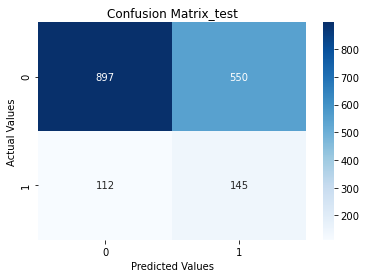

In [35]:
y_pred_test=logit_model_final.predict(x_test[significant_vars])
cnf_matrix_test = metrics.confusion_matrix(y_test, y_pred_test)
print(cnf_matrix_test)
cm_test=confusion_matrix(y_test,y_pred_test)
plt.figure(figsize=(6,4))
plt.title("Confusion Matrix_test")
sns.heatmap(cm_test, annot=True,fmt='d', cmap='Blues')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.62      0.73      1447
           1       0.21      0.56      0.30       257

    accuracy                           0.61      1704
   macro avg       0.55      0.59      0.52      1704
weighted avg       0.79      0.61      0.67      1704



In [37]:
## surely there will be other modeling strategies and a more effective hyperparameter tuning process. 
# for the time being, I will stop the analytic process for now. 